In [2]:
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
from scipy.stats.mstats import winsorize
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.outliers_influence import variance_inflation_factor

import os
import warnings
import pandas as pd
import seaborn as sns

In [3]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

In [4]:
input_dir = '../Database/'
file_train = 'train.csv'
file_test = 'test.csv'
train = pd.read_csv(os.path.join(input_dir, file_train))
test = pd.read_csv(os.path.join(input_dir, file_test))

In [5]:
# train

In [6]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출기간']))
train['대출기간'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['대출기간']))
test['대출기간'] = pd.DataFrame(encoder_data)

In [7]:
train['근로기간'] = train['근로기간'].str.extract(r'(\d+)')
train['근로기간'] = train['근로기간'].fillna(0)
train['근로기간'] = train['근로기간'].astype(int)

test['근로기간'] = test['근로기간'].str.extract(r'(\d+)')
test['근로기간'] = test['근로기간'].fillna(0)
test['근로기간'] = test['근로기간'].astype(int)

In [8]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['주택소유상태']))
train['주택소유상태'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['주택소유상태']))
test['주택소유상태'] = pd.DataFrame(encoder_data)

In [9]:
test.loc[34486, '대출목적'] = '기타'

In [10]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출목적']))
train['대출목적'] = pd.DataFrame(encoder_data)

encoder_data = label_encoder.transform(list(test['대출목적']))
test['대출목적'] = pd.DataFrame(encoder_data)

In [11]:
label_encoder = LabelEncoder()
encoder_data = label_encoder.fit_transform(list(train['대출등급']))
train['대출등급'] = pd.DataFrame(encoder_data)

In [12]:
train.set_index(train['ID'], inplace=True)
train.drop(columns='ID', inplace=True)

test.set_index(test['ID'], inplace=True)
test.drop(columns='ID', inplace=True)

In [13]:
def do_pca(X_pca):
    columns_pca = [f'PCA_{i}' for i in range(1, X_pca.shape[1] + 1)]
    X_pca_df = pd.DataFrame(X_pca, columns=columns_pca)
    return X_pca_df

In [14]:
scaler = StandardScaler()
pca = PCA(n_components=0.99)

gt = pd.DataFrame(train['대출등급'], columns=['대출등급'])
to_normalize_list = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
X = pd.DataFrame(train[to_normalize_list], columns=to_normalize_list, index=train.index)
Y = pd.DataFrame(test[to_normalize_list], columns=to_normalize_list, index=test.index)

data_scaled = scaler.fit_transform(X)
# X_pca = pca.fit_transform(data_scaled)
# data_scaled = do_pca(X_pca)
# data_scaled.index = train.index

data_scaled = pd.DataFrame(data_scaled, columns=to_normalize_list, index=train.index)

train.drop(columns=to_normalize_list, inplace=True)
train.drop(columns='대출등급', inplace=True)
train = pd.concat([gt, data_scaled, train], axis=1)

data_scaled = scaler.transform(Y)
# X_pca = pca.transform(data_scaled)
# data_scaled = do_pca(X_pca)
# data_scaled.index = test.index

data_scaled = pd.DataFrame(data_scaled, columns=to_normalize_list, index=test.index)

test.drop(columns=to_normalize_list, inplace=True)
test = pd.concat([data_scaled, test], axis=1)
# print(pca.explained_variance_ratio_)

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

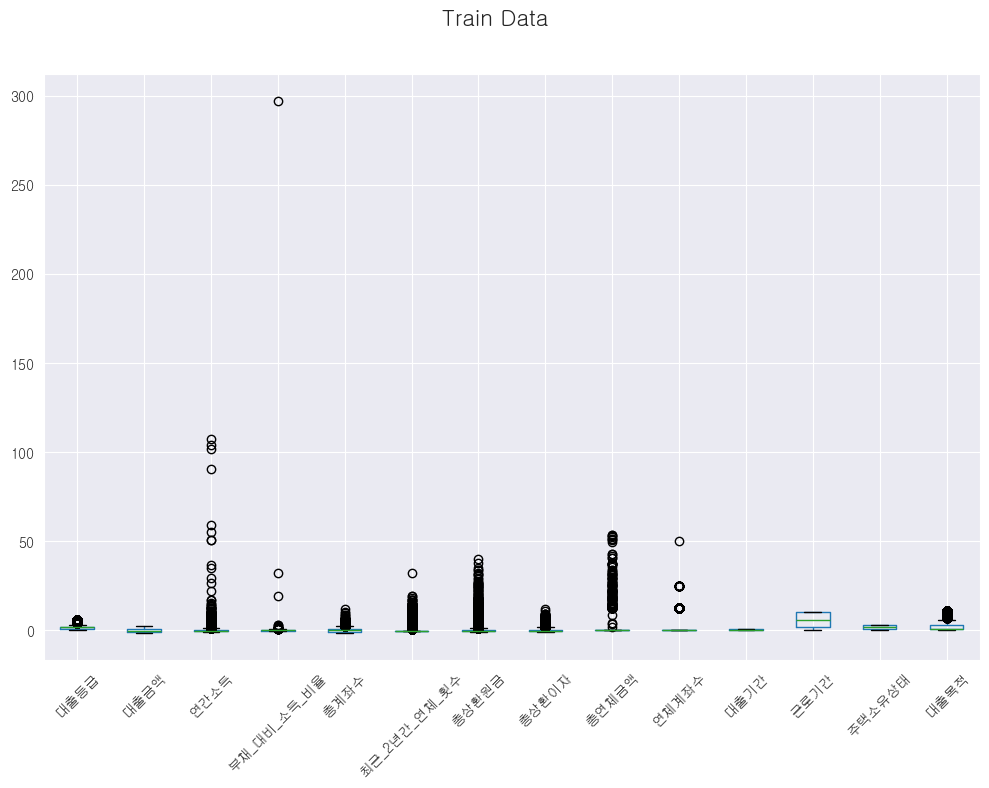

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [16]:
columns = ['대출금액', '연간소득', '부채_대비_소득_비율', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총계좌수', '총연체금액', '연체계좌수']

for col in columns:
    train[col] = winsorize(train[col], limits=[0.002, 0.002])

<Axes: >

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, '대출등급'),
  Text(2, 0, '대출금액'),
  Text(3, 0, '연간소득'),
  Text(4, 0, '부채_대비_소득_비율'),
  Text(5, 0, '총계좌수'),
  Text(6, 0, '최근_2년간_연체_횟수'),
  Text(7, 0, '총상환원금'),
  Text(8, 0, '총상환이자'),
  Text(9, 0, '총연체금액'),
  Text(10, 0, '연체계좌수'),
  Text(11, 0, '대출기간'),
  Text(12, 0, '근로기간'),
  Text(13, 0, '주택소유상태'),
  Text(14, 0, '대출목적')])

Text(0.5, 0.98, 'Train Data')

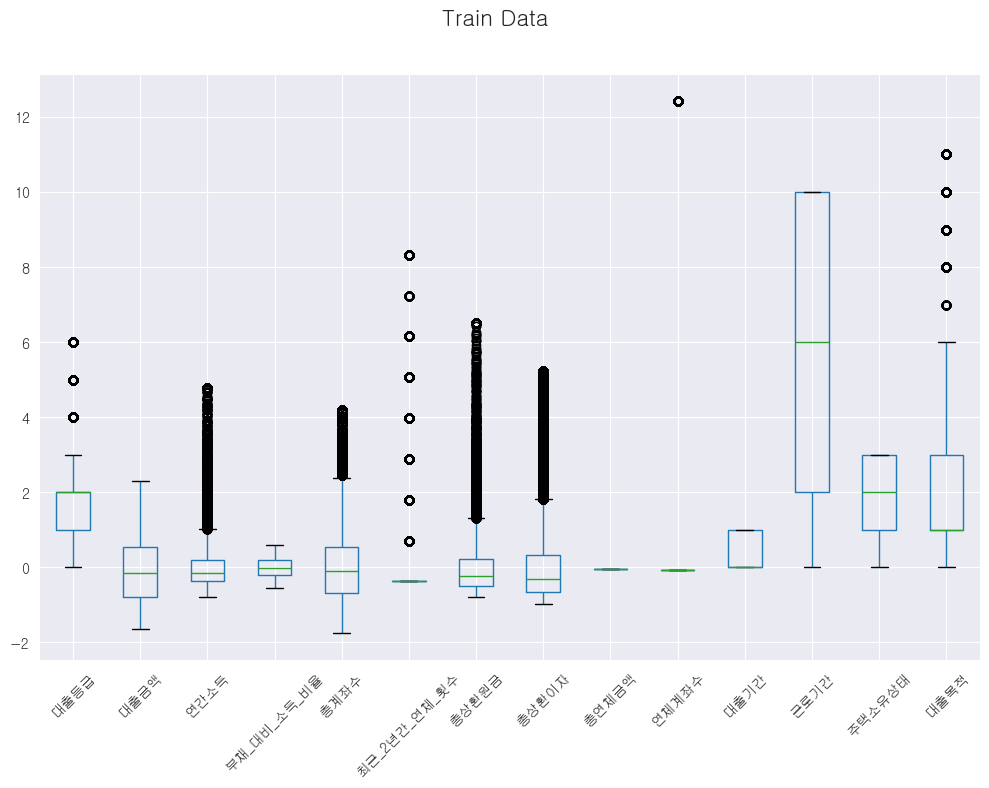

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
train.boxplot(ax=ax)
plt.xticks(rotation=45)
fig.suptitle('Train Data', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

In [18]:
X = train.drop(columns=['대출등급'])
y = train['대출등급']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'n_estimators': 100,
    'criterion': 'entropy',
    'max_depth': 80,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'class_weight': 'balanced',
}

rf_model = RandomForestClassifier(**params)
rf_model.fit(X_train, y_train)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_model.predict(X_test)))

feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values(
    'Importance', ascending=False)
print(feature_importances)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=80, min_samples_leaf=2)

Random Forest Accuracy: 0.8100109039929384
              Importance
총상환이자           0.277078
총상환원금           0.237653
대출금액            0.096532
연간소득            0.078577
대출기간            0.077693
부채_대비_소득_비율     0.075931
총계좌수            0.059785
근로기간            0.036408
대출목적            0.030133
주택소유상태          0.016944
최근_2년간_연체_횟수    0.013007
연체계좌수           0.000260
총연체금액           0.000000


In [19]:
category_list = ['대출기간', '근로기간', '주택소유상태', '대출목적']

for i in range(len(category_list)):
    contingency_table = pd.crosstab(train['대출등급'], train[category_list[i]])
    chi, p, dof, _ = chi2_contingency(contingency_table)
    print(f'{category_list[i]}: p_value = {p:.2f}, chi = {chi:.3f}, Degree Of Freedom = {dof}')

대출기간: p_value = 0.00, chi = 19134.184, Degree Of Freedom = 6
근로기간: p_value = 0.00, chi = 145.508, Degree Of Freedom = 60
주택소유상태: p_value = 0.00, chi = 663.433, Degree Of Freedom = 18
대출목적: p_value = 0.00, chi = 5744.213, Degree Of Freedom = 66


In [20]:
X = train[to_normalize_list]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

       Variable       VIF
0          대출금액  2.090204
1          연간소득  1.486071
2   부채_대비_소득_비율  1.203426
3          총계좌수  1.198356
4  최근_2년간_연체_횟수  1.038663
5         총상환원금  1.520070
6         총상환이자  1.907602
7         총연체금액  1.001694
8         연체계좌수  1.019592


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Pearson Correlation Heatmap')

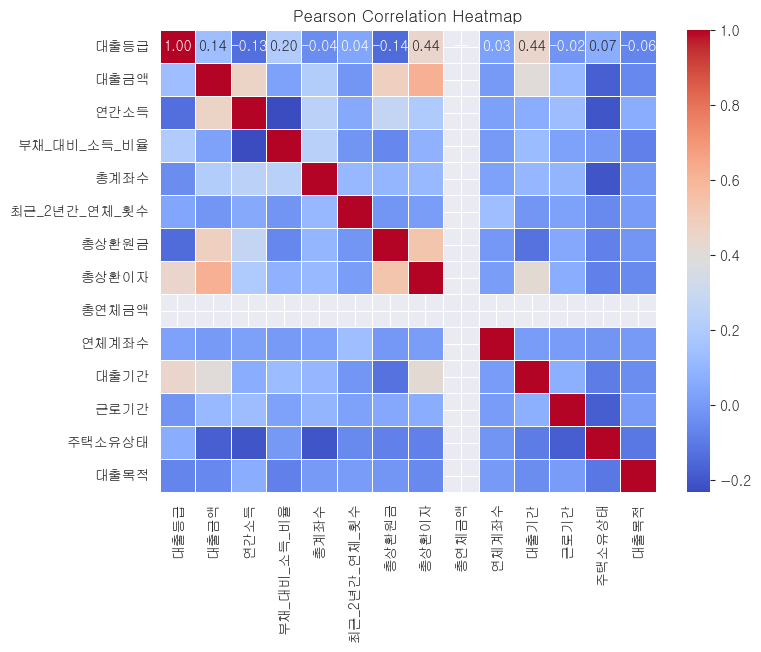

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Spearman Correlation Heatmap')

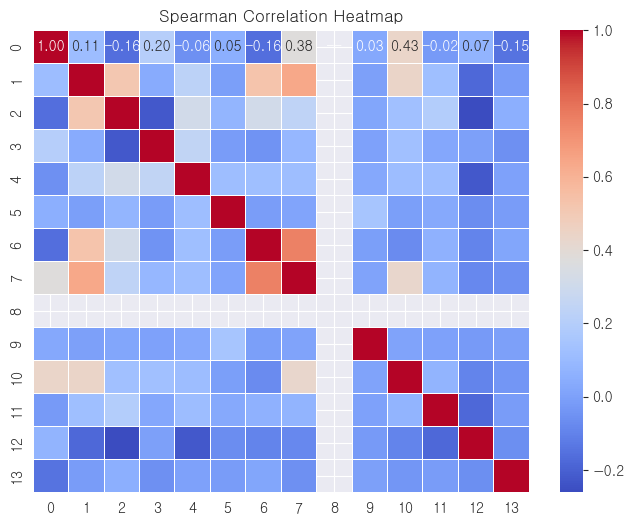

In [21]:
correlation_matrix = train.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

correlation_matrix, _ = spearmanr(train)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.show()

In [22]:
train.drop(columns=['최근_2년간_연체_횟수','총연체금액', '연체계좌수','근로기간'], inplace=True)
test.drop(columns=['최근_2년간_연체_횟수', '총연체금액', '연체계좌수','근로기간'], inplace=True)

In [23]:
train.to_csv('../Database/train_preprocessed.csv')
test.to_csv('../Database/test_preprocessed.csv')